In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_ta as ta   ~~ Uncomment if the issue with pandas_ta is resolved

## Feature Engineering


- First let's do the minimal cleaning steps

In [6]:
#Get the data again, skip first 3 rows and set column names
data_path = '../data/sp500.csv'
col_names = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df = pd.read_csv(data_path, skiprows=3, names=col_names)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
numeric_cols = ['Close', 'High', 'Low', 'Open', 'Volume']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df.ffill(inplace=True)
df.dropna(inplace=True)


In [10]:
if 'Daily_Return' not in df.columns:
    df['Daily_Return'] = df['Close'].pct_change() * 100
    df.dropna(subset=['Daily_Return'], inplace=True)


#print("Data loaded and initially prepared:")
#print(df.head())
#print(f"\nData shape: {df.shape}")
#print(f"\nDate range: {df.index.min()} to {df.index.max()}")

### Feature 1: Lagged Returns

In [12]:
n_lags = 5
for i in range(1, n_lags + 1):
    df[f'Return_Lag_{i}'] = df['Daily_Return'].shift(i)

### Feature 2: Rolling Volatilty

In [14]:
volatility_window = 21 
trading_days_per_year = 252 
if 'Daily_Return' in df.columns:
    df['Rolling_Std_Dev'] = df['Daily_Return'].rolling(window=volatility_window).std()
    df['Annualized_Volatility'] = df['Rolling_Std_Dev'] * np.sqrt(trading_days_per_year)
else:
    print("Warning: Daily_Return column needed for volatility calculation.")


### Feature 3: Volume

In [15]:
volume_window = 50
df['Volume_SMA'] = df['Volume'].rolling(window=volume_window).mean()
df['Volume_Ratio'] = df['Volume'] / (df['Volume_SMA'] + 1e-6) # Avoid division by zero

### Feature 4: Moving Averages

In [16]:
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean() 
df['SMA_200'] = df['Close'].rolling(window=200).mean()
# Calculate ratio between short/medium and long term trends
df['SMA_Ratio_50_200'] = df['SMA_50'] / (df['SMA_200'] + 1e-6)

### Feature 5: Time

In [17]:
df['Day_Of_Week'] = df.index.dayofweek
df['Month'] = df.index.month
#df['Year'] = df.index.year  ~~can add later if needed

### Get Rid of NaNs

In [ ]:
#Clean up NaNs introduced by shifts and rolling windows
print(f"\nNaNs before final drop:\n{df.isnull().sum()}")
df.dropna(inplace=True)
print(f"\nNaNs after final drop:\n{df.isnull().sum()}")
print(f"\nShape after feature engineering & NaN drop: {df.shape}")



NaNs before final drop:
Close                    0
High                     0
Low                      0
Open                     0
Volume                   0
Daily_Return             0
Return_Lag_1             0
Return_Lag_2             0
Return_Lag_3             0
Return_Lag_4             0
Return_Lag_5             0
Rolling_Std_Dev          0
Annualized_Volatility    0
Volume_SMA               0
Volume_Ratio             0
SMA_10                   0
SMA_50                   0
SMA_200                  0
SMA_Ratio_50_200         0
Day_Of_Week              0
Month                    0
dtype: int64

NaNs after final drop:
Close                    0
High                     0
Low                      0
Open                     0
Volume                   0
Daily_Return             0
Return_Lag_1             0
Return_Lag_2             0
Return_Lag_3             0
Return_Lag_4             0
Return_Lag_5             0
Rolling_Std_Dev          0
Annualized_Volatility    0
Volume_SMA          

In [24]:
feature_columns = [f'Return_Lag_{i}' for i in range(1, n_lags + 1)] + \
                  ['Annualized_Volatility', 'Volume_Ratio',
                   'SMA_Ratio_50_200',
                   'Day_Of_Week', 'Month']

#You could also include the raw SMA values if desired, e.g., 'SMA_10', 'SMA_50'
#feature_columns.extend(['SMA_10', 'SMA_50'])


print(feature_columns)

['Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4', 'Return_Lag_5', 'Annualized_Volatility', 'Volume_Ratio', 'SMA_Ratio_50_200', 'Day_Of_Week', 'Month']


In [26]:
print(f"\nDataFrame head with engineered features:")
print(df[feature_columns + ['Daily_Return']].head()) # Show features and target


target_column = 'Daily_Return'


DataFrame head with engineered features:
            Return_Lag_1  Return_Lag_2  Return_Lag_3  Return_Lag_4  \
Date                                                                 
1970-10-15      0.154657     -0.130689     -1.069586     -1.012211   
1970-10-16      0.546382      0.154657     -0.130689     -1.069586   
1970-10-19     -0.437097      0.546382      0.154657     -0.130689   
1970-10-20     -1.340766     -0.437097      0.546382      0.154657   
1970-10-21      0.589294     -1.340766     -0.437097      0.546382   

            Return_Lag_5  Annualized_Volatility  Volume_Ratio  \
Date                                                            
1970-10-15     -1.081830              12.324530      0.869653   
1970-10-16     -1.012211              12.382907      0.868496   
1970-10-19     -1.069586              13.314065      0.759519   
1970-10-20     -0.130689              13.032340      0.812542   
1970-10-21      0.154657              13.022202      0.860785   

           

## Train/Val/Test

In [27]:
#Define Split Date
train_end_date = '2017-12-31'
validation_end_date = '2020-12-31'
#The test data will be everything after validation_end_date

In [28]:
# Training Set
df_train = df.loc[:train_end_date]

# Validation Set
df_val = df.loc[pd.to_datetime(train_end_date) + pd.Timedelta(days=1) : validation_end_date]

# Test Set
df_test = df.loc[pd.to_datetime(validation_end_date) + pd.Timedelta(days=1):]

In [ ]:
#Features and targets
X_train = df_train[feature_columns]
y_train = df_train[target_column]

X_val = df_val[feature_columns]
y_val = df_val[target_column]

X_test = df_test[feature_columns]
y_test = df_test[target_column]

In [30]:
#Verify the Split
print("--- Data Split Verification ---")
print(f"Total data shape: {df.shape}")
print("-" * 30)
print(f"Training Set:")
print(f"  Date Range: {df_train.index.min().date()} to {df_train.index.max().date()}")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print("-" * 30)
print(f"Validation Set:")
print(f"  Date Range: {df_val.index.min().date()} to {df_val.index.max().date()}")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_val shape: {y_val.shape}")
print("-" * 30)
print(f"Test Set:")
print(f"  Date Range: {df_test.index.min().date()} to {df_test.index.max().date()}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")

--- Data Split Verification ---
Total data shape: (13671, 21)
------------------------------
Training Set:
  Date Range: 1970-10-15 to 2017-12-29
  X_train shape: (11910, 10)
  y_train shape: (11910,)
------------------------------
Validation Set:
  Date Range: 2018-01-02 to 2020-12-31
  X_val shape: (756, 10)
  y_val shape: (756,)
------------------------------
Test Set:
  Date Range: 2021-01-04 to 2024-12-31
  X_test shape: (1005, 10)
  y_test shape: (1005,)


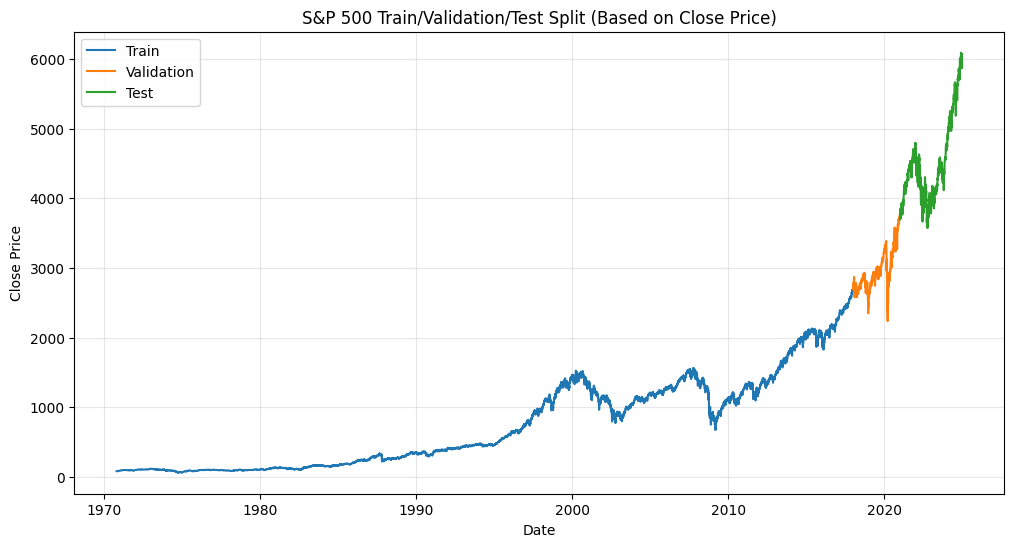

In [32]:
#Plot the splits visually
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['Close'], label='Train')
plt.plot(df_val.index, df_val['Close'], label='Validation')
plt.plot(df_test.index, df_test['Close'], label='Test')
plt.title('S&P 500 Train/Validation/Test Split (Based on Close Price)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Scaling Data

In [34]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler() #Features between 0 and 1


scaler.fit(X_train) # Fit the scaler on the training data



#Transform the data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [35]:
#Convert scaled data back into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


In [37]:
#Verify the Scaling
print("\n--- Scaled Data Verification ---")
print("Original X_train head:")
print(X_train.head())
print("\nScaled X_train head (MinMaxScaler to [0, 1]):")
print(X_train_scaled_df.head())


--- Scaled Data Verification ---
Original X_train head:
            Return_Lag_1  Return_Lag_2  Return_Lag_3  Return_Lag_4  \
Date                                                                 
1970-10-15      0.154657     -0.130689     -1.069586     -1.012211   
1970-10-16      0.546382      0.154657     -0.130689     -1.069586   
1970-10-19     -0.437097      0.546382      0.154657     -0.130689   
1970-10-20     -1.340766     -0.437097      0.546382      0.154657   
1970-10-21      0.589294     -1.340766     -0.437097      0.546382   

            Return_Lag_5  Annualized_Volatility  Volume_Ratio  \
Date                                                            
1970-10-15     -1.081830              12.324530      0.869653   
1970-10-16     -1.012211              12.382907      0.868496   
1970-10-19     -1.069586              13.314065      0.759519   
1970-10-20     -0.130689              13.032340      0.812542   
1970-10-21      0.154657              13.022202      0.860785 

In [40]:
print("\nScaled X_val head:") # Show the scaled validation set
print(X_val_scaled_df.head())

#we leave the target variable (y) unscaled for interpretability (for now).


Scaled X_val head:
            Return_Lag_1  Return_Lag_2  Return_Lag_3  Return_Lag_4  \
Date                                                                 
2018-01-02      0.622481      0.644377      0.641122      0.635352   
2018-01-03      0.664564      0.622481      0.644377      0.641122   
2018-01-04      0.658621      0.664564      0.622481      0.644377   
2018-01-05      0.651225      0.658621      0.664564      0.622481   
2018-01-08      0.660603      0.651225      0.658621      0.664564   

            Return_Lag_5  Annualized_Volatility  Volume_Ratio  \
Date                                                            
2018-01-02      0.637225               0.029146      0.313468   
2018-01-03      0.635352               0.031250      0.327192   
2018-01-04      0.641122               0.031361      0.340850   
2018-01-05      0.644377               0.031078      0.297558   
2018-01-08      0.622481               0.030570      0.299369   

            SMA_Ratio_50_200  Day

## Creating Sequences

We transform our flat table of features over time into the kind of "lookback windows" that LSTMs and Transformers need.
- 30 days is a good window for the sequence

In [41]:
def create_sequences(X_data, y_data, sequence_length):
    """
    Generates sequences from time series data for LSTM/Transformer models.

    Args:
        X_data (np.array): Array of input features (scaled). Shape (num_datapoints, num_features).
        y_data (pd.Series or np.array): Array of target variable. Shape (num_datapoints,).
        sequence_length (int): Number of time steps in each input sequence.

    Returns:
        tuple: (np.array of X sequences, np.array of y targets)
               X shape: (num_samples, sequence_length, num_features)
               y shape: (num_samples,)
    """
    X_sequences = []
    y_sequences = []


    if not isinstance(y_data, np.ndarray):
        y_data = y_data.to_numpy()



    #Iterate through the data to create sequences
    for i in range(len(X_data) - sequence_length):
        #Input sequence: from index i to i + sequence_length - 1
        X_sequences.append(X_data[i : i + sequence_length])
        #Target: the value at index i + sequence_length
        y_sequences.append(y_data[i + sequence_length])

    return np.array(X_sequences), np.array(y_sequences)

In [43]:
SEQUENCE_LENGTH = 30 # Look back 30 days


if isinstance(X_train_scaled, pd.DataFrame): #Check if conversion to DataFrame happened
    X_train_np = X_train_scaled.values
    X_val_np = X_val_scaled.values
    X_test_np = X_test_scaled.values
else: #Assume they are already NumPy arrays
    X_train_np = X_train_scaled
    X_val_np = X_val_scaled
    X_test_np = X_test_scaled


X_train_seq, y_train_seq = create_sequences(X_train_np, y_train, SEQUENCE_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val_np, y_val, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_np, y_test, SEQUENCE_LENGTH)

In [45]:
#Verify the Shapes
print("\nSequence Shapes Verification")
print(f"X_train shape: {X_train_np.shape} -> X_train_seq shape: {X_train_seq.shape}")
print(f"y_train shape: {y_train.shape} -> y_train_seq shape: {y_train_seq.shape}")
print("-" * 30)
print(f"X_val shape:   {X_val_np.shape} -> X_val_seq shape:   {X_val_seq.shape}")
print(f"y_val shape:   {y_val.shape} -> y_val_seq shape:   {y_val_seq.shape}")
print("-" * 30)
print(f"X_test shape:  {X_test_np.shape} -> X_test_seq shape:  {X_test_seq.shape}")
print(f"y_test shape:  {y_test.shape} -> y_test_seq shape:  {y_test_seq.shape}")


Sequence Shapes Verification
X_train shape: (11910, 10) -> X_train_seq shape: (11880, 30, 10)
y_train shape: (11910,) -> y_train_seq shape: (11880,)
------------------------------
X_val shape:   (756, 10) -> X_val_seq shape:   (726, 30, 10)
y_val shape:   (756,) -> y_val_seq shape:   (726,)
------------------------------
X_test shape:  (1005, 10) -> X_test_seq shape:  (975, 30, 10)
y_test shape:  (1005,) -> y_test_seq shape:  (975,)
